In [ ]:
import os
import collections
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms
from tqdm import tqdm
import pickle
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes
from torchvision.datasets import VOCDetection
from torchvision.ops import batched_nms

#**Data Preprocessing**

In [ ]:
dataset =  torchvision.datasets.VOCDetection(
    root = './data',
    download = True,
    image_set = 'train'
)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
len(dataset)

5717

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=500x442>,
 {'annotation': {'folder': 'VOC2012',
   'filename': '2008_000008.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '442', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'horse',
     'pose': 'Left',
     'truncated': '0',
     'occluded': '1',
     'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
     'difficult': '0'},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '1',
     'occluded': '0',
     'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
     'difficult': '0'}]}})

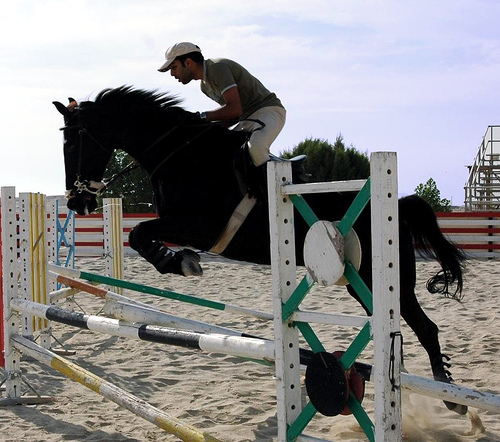

In [ ]:
dataset[0][0]

In [ ]:
target_count = {}

for item in dataset:
    objects = item[1]['annotation']['object']
    for obj in objects:
        obj_name = obj['name']
        if obj_name in target_count:
            target_count[obj_name] += 1
        else:
            target_count[obj_name] = 1

print("Num of targets:", len(target_count))
print("Target names and counts:", target_count)


Num of targets: 20
Target names and counts: {'horse': 377, 'person': 5019, 'bottle': 749, 'dog': 768, 'tvmonitor': 412, 'car': 1191, 'aeroplane': 470, 'bicycle': 410, 'boat': 508, 'chair': 1457, 'diningtable': 373, 'pottedplant': 557, 'train': 327, 'cat': 609, 'sofa': 399, 'bird': 592, 'sheep': 509, 'motorbike': 375, 'bus': 317, 'cow': 355}


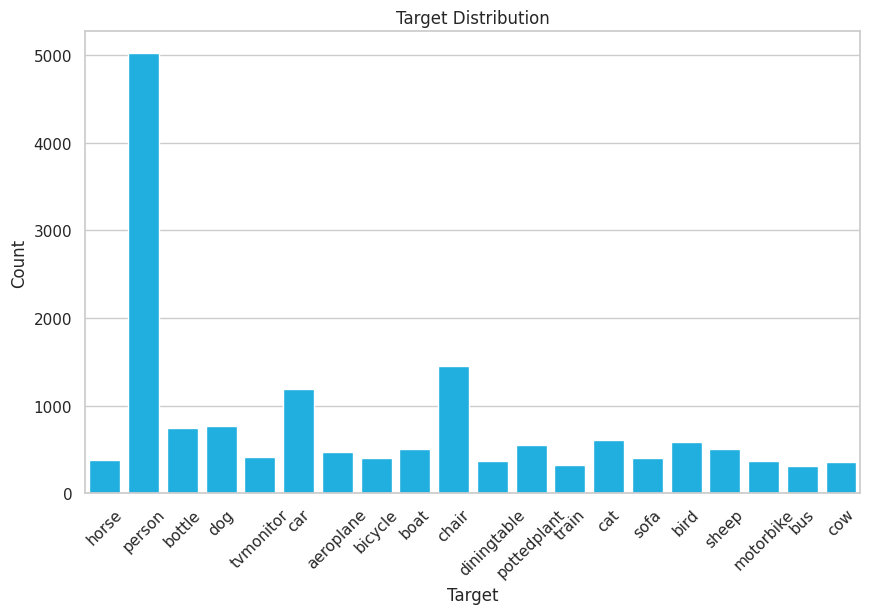

In [ ]:
targets = list(target_count.keys())
counts = list(target_count.values())

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = plt.gca()
sns.barplot(x=targets, y=counts, ax=ax, color='deepskyblue')
ax.set_title('Target Distribution')
ax.set_xlabel('Target')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Bộ dữ liệu cung cấp có 20 class cần dự đoán, trong đó:


In [ ]:
# Label Encoding
target2idx = {name: i for i, name in enumerate(target_count.keys())}
idx2target = {i: name for i, name in enumerate(target_count.keys())}

print("target2idx:", target2idx)
print("idx2target:", idx2target)

target2idx: {'horse': 0, 'person': 1, 'bottle': 2, 'dog': 3, 'tvmonitor': 4, 'car': 5, 'aeroplane': 6, 'bicycle': 7, 'boat': 8, 'chair': 9, 'diningtable': 10, 'pottedplant': 11, 'train': 12, 'cat': 13, 'sofa': 14, 'bird': 15, 'sheep': 16, 'motorbike': 17, 'bus': 18, 'cow': 19}
idx2target: {0: 'horse', 1: 'person', 2: 'bottle', 3: 'dog', 4: 'tvmonitor', 5: 'car', 6: 'aeroplane', 7: 'bicycle', 8: 'boat', 9: 'chair', 10: 'diningtable', 11: 'pottedplant', 12: 'train', 13: 'cat', 14: 'sofa', 15: 'bird', 16: 'sheep', 17: 'motorbike', 18: 'bus', 19: 'cow'}


In [ ]:
def target_transform(voc_target):
    boxes = []
    labels = []

    for obj in voc_target["annotation"]["object"]:
        # Lấy thông tin bounding box
        xmin = float(obj["bndbox"]["xmin"])
        ymin = float(obj["bndbox"]["ymin"])
        xmax = float(obj["bndbox"]["xmax"])
        ymax = float(obj["bndbox"]["ymax"])

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(target2idx[obj["name"]])

    # Chuyển đổi danh sách thành Tensor của PyTorch
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    # Trả về từ điển kết quả chứa thông tin đã xử lý
    return {"boxes": boxes, "labels": labels}


In [ ]:
target_transform(dataset[0][1])

{'boxes': tensor([[ 53.,  87., 471., 420.],
         [158.,  44., 289., 167.]]),
 'labels': tensor([0, 1])}

In [ ]:
def imshow(imgs):
    to_pil = torchvision.transforms.ToPILImage()
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 6))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [ ]:
def draw_boxes(image, boxes, labels):
    colors = ["red" for _ in boxes]
    imshow(draw_bounding_boxes(image, boxes, labels, colors=colors, width=2))

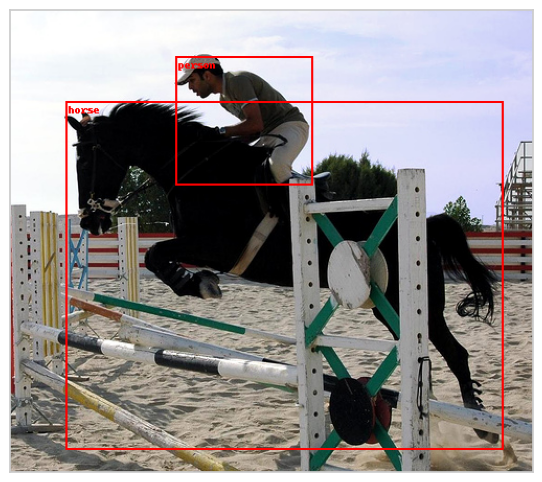

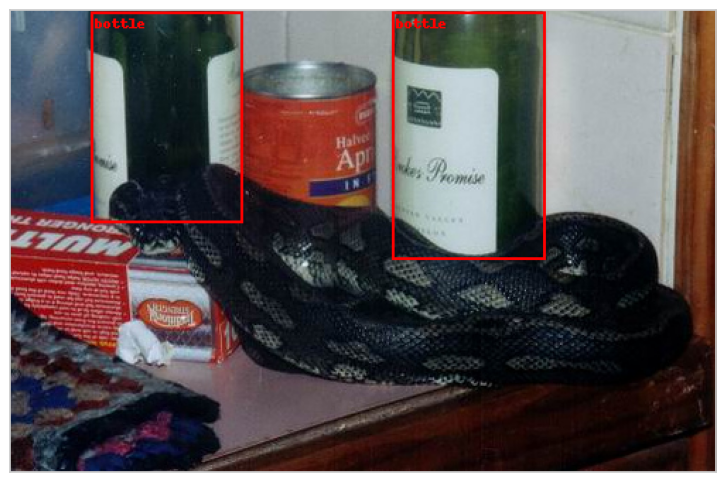

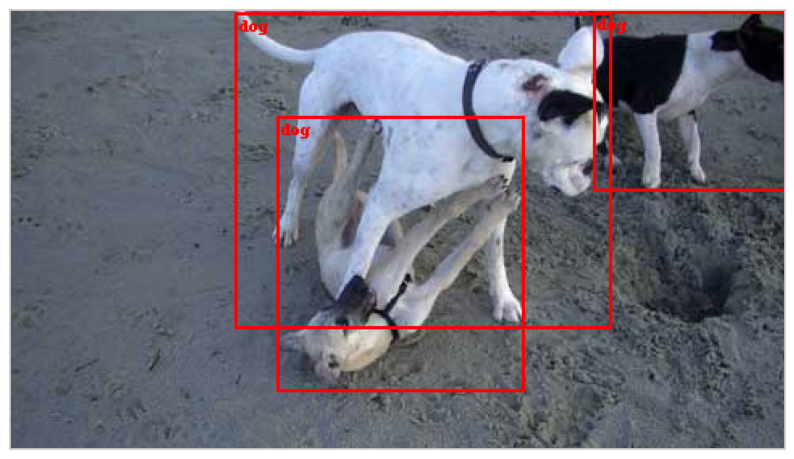

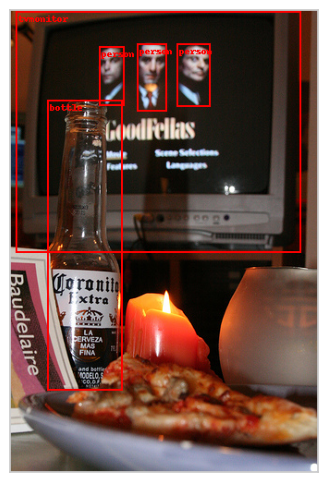

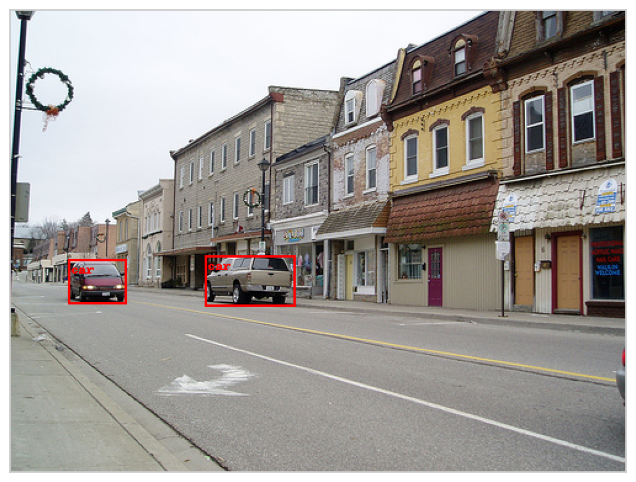

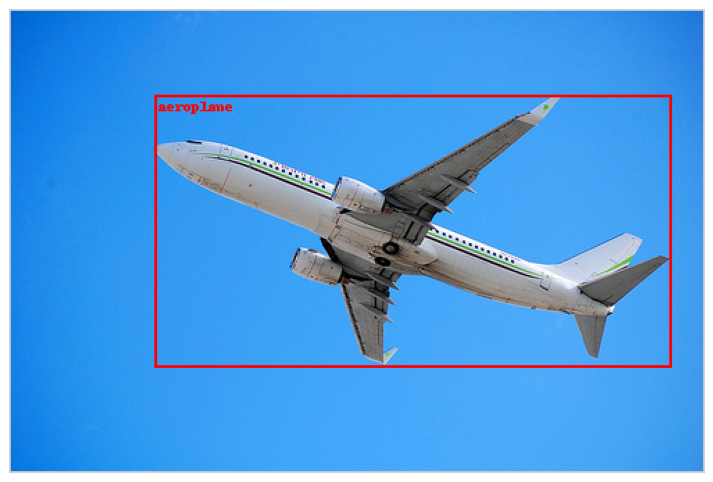

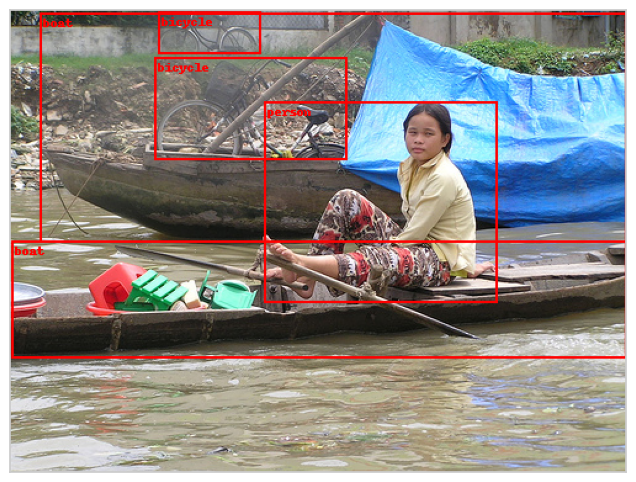

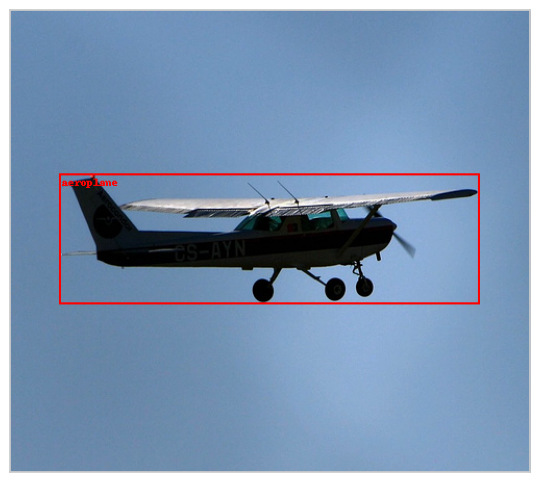

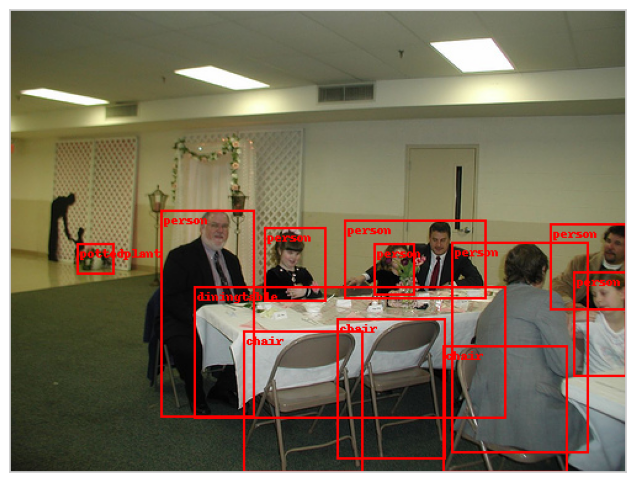

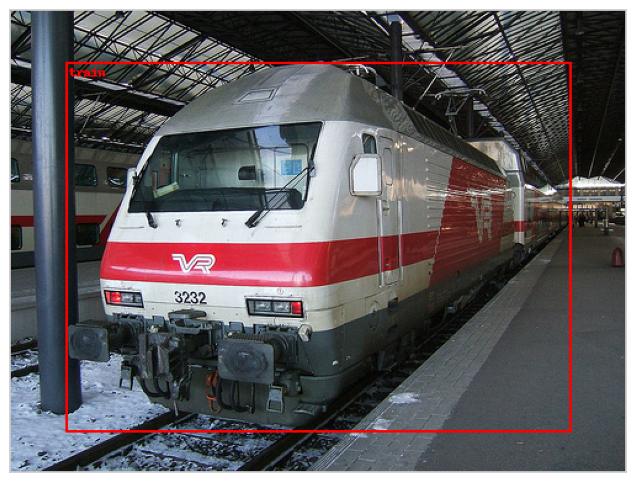

In [ ]:
for i in range(10):
    draw_boxes(
        torchvision.transforms.PILToTensor()(dataset[i][0]),
        target_transform(dataset[i][1])['boxes'],
        [idx2target[label.item()] for label in target_transform(dataset[i][1])['labels']]
    )

#**Data Loader**

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDetection(
    root = './data',
    image_set = 'train',
    transform = torchvision.transforms.ToTensor(),
    target_transform = target_transform
)

validation_dataset = VOCDetection(
    root = './data',
    image_set = 'val',
    transform = torchvision.transforms.ToTensor(),
    target_transform = target_transform
)

In [ ]:
from torch.utils.data import SubsetRandomSampler

def create_sampler(dataset, ratio):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    np.random.shuffle(indices)
    reduced_size = int(np.floor(num_samples * ratio))
    subset_indices = indices[:reduced_size]
    print("Sampled size:", reduced_size)
    return SubsetRandomSampler(subset_indices)

In [ ]:
train_sampler = create_sampler(train_dataset, ratio=1.0)
validation_sampler = create_sampler(validation_dataset, ratio=0.7)

Sampled size: 5717
Sampled size: 4076


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 8,
    sampler = train_sampler,
    collate_fn = collate_fn,
)

validation_loader = torch.utils.data.DataLoader(
    dataset = validation_dataset,
    batch_size = 8,
    sampler = validation_sampler,
    collate_fn = collate_fn,
)

In [ ]:
print("Number of batches in train loader:", len(train_loader))
print("Number of batches in validation loader:", len(validation_loader))

Number of batches in train loader: 715
Number of batches in validation loader: 510


#**Create Model**

In [ ]:
num_classes = 20
num_epochs = 10

In [ ]:
# Tính toán chỉ số IoU giữa 2 bounding boxes:
def intersection_over_union(dt_bbox, gt_bbox):
    # Tính điểm góc trên bên trái của khu vực giao nhau
    int_x0 = max(dt_bbox[0], gt_bbox[0])
    int_y0 = max(dt_bbox[1], gt_bbox[1])

    # Tính điểm góc dưới bên phải của khu vực giao nhau
    int_x1 = min(dt_bbox[2], gt_bbox[2])
    int_y1 = min(dt_bbox[3], gt_bbox[3])

    # Tính diện tích của khu vực giao nhau
    intersection = max(int_x1 - int_x0, 0) * max(int_y1 - int_y0, 0)

    # Tính diện tích của từng hộp giới hạn
    dt_area = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    return intersection / (dt_area + gt_area - intersection)


In [ ]:
# Hàm dùng để loại bỏ các hộp giới hạn dư thừa trong dự đoán sử dụng thuật toán Non-Maximum Suppression (NMS)
def apply_nms(orig_prediction, iou_thresh = 0.3):

    keep = batched_nms(orig_prediction['boxes'], orig_prediction['scores'], orig_prediction['labels'], iou_thresh)

    final_prediction = orig_prediction

    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

In [ ]:
@torch.inference_mode()
def visualize(model, batch):
    model.eval()
    to_pil = torchvision.transforms.ToPILImage()
    to_tensor = torchvision.transforms.PILToTensor()
    xs, ys = batch

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = {k: v.to(device) for k, v in model([x.to(device)])[0].items()}
        prediction = apply_nms(prediction)
        x = to_tensor(to_pil(x.cpu()))

        true_boxes = draw_bounding_boxes(x, boxes=y['boxes'], labels=[idx2target[label.item()] for label in y['labels']], width=2, colors='red')
        predicted_boxes = draw_bounding_boxes(x, boxes=prediction['boxes'], labels=[idx2target[label.item()] for label in prediction['labels']], width=2, colors='blue')

        fig, ax = plt.subplots(1, 2, figsize=(10, 8), facecolor='white')

        ax[0].imshow(to_pil(true_boxes))
        ax[1].imshow(to_pil(predicted_boxes))

        ax[0].axis('off')
        ax[1].axis('off')

        ax[0].set_title('Target boxes')
        ax[1].set_title('Predicted boxes')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

##**Faster R-CNN Model**
*(Sử dụng mô hình đã được pre_trained sẵn)*

In [ ]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
def get_detection_model(num_classes):
    model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
modelRCNN = get_detection_model(num_classes)
modelRCNN

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelRCNN = modelRCNN.to(device)
optimizer = torch.optim.SGD(modelRCNN.parameters(), lr = 1e-3, momentum = 0.4)

In [ ]:
def train_model(model):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader, desc='Training'):
        x = [item.to(device).float() for item in x]
        y = [{k: v.to(device) for k, v in t.items()} for t in y]

        optimizer.zero_grad()
        output = model(x, y)
        loss = sum(loss for loss in output.values())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [ ]:
!pip install torchmetrics
!pip install pycocotools
!pip install torchmetrics[detection]

In [ ]:
import pycocotools
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()
    metric = MeanAveragePrecision(iou_type='bbox', iou_thresholds=[0.5])
    for x, y in tqdm(loader, desc='Evaluation'):
        x = list(_.to(device).float() for _ in x)
        output = model(x)
        output = [{k: v.cpu() for k, v in t.items()} for t in output]
        metric.update(output, y)
    return metric.compute()['map']

In [ ]:
def main_loop(model, train_loader, test_loader, optimizer, num_epochs):
    train_losses = []
    test_maps = []

    for epoch in range(num_epochs):
        # Train the model on the training dataset
        train_loss = train_model(model)
        train_losses.append(train_loss)

        # Evaluate on the test dataset
        test_map = evaluate(model, test_loader)
        test_maps.append(test_map)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test MAP: {test_map:.4f}')

    return train_losses, test_maps

In [ ]:
train_losses, test_maps = main_loop(modelRCNN, train_loader, validation_loader, optimizer, num_epochs)

Evaluation: 100%|██████████| 510/510 [01:01<00:00,  8.31it/s]


Epoch 1/10, Train Loss: 1.5101, Test MAP: 0.5034


Evaluation: 100%|██████████| 510/510 [00:56<00:00,  8.98it/s]


Epoch 2/10, Train Loss: 1.0134, Test MAP: 0.5944


Evaluation: 100%|██████████| 510/510 [00:58<00:00,  8.78it/s]


Epoch 3/10, Train Loss: 0.8591, Test MAP: 0.6152


Evaluation: 100%|██████████| 510/510 [01:07<00:00,  7.56it/s]


Epoch 4/10, Train Loss: 0.7906, Test MAP: 0.6231


Evaluation: 100%|██████████| 510/510 [01:00<00:00,  8.43it/s]


Epoch 5/10, Train Loss: 0.7502, Test MAP: 0.6316


Evaluation: 100%|██████████| 510/510 [01:01<00:00,  8.35it/s]


Epoch 6/10, Train Loss: 0.7210, Test MAP: 0.6338


Evaluation: 100%|██████████| 510/510 [01:00<00:00,  8.50it/s]


Epoch 7/10, Train Loss: 0.6901, Test MAP: 0.6378


Evaluation: 100%|██████████| 510/510 [01:00<00:00,  8.47it/s]


Epoch 8/10, Train Loss: 0.6750, Test MAP: 0.6398


Evaluation: 100%|██████████| 510/510 [01:01<00:00,  8.33it/s]


Epoch 9/10, Train Loss: 0.6674, Test MAP: 0.6417


Evaluation: 100%|██████████| 510/510 [01:00<00:00,  8.42it/s]


Epoch 10/10, Train Loss: 0.6465, Test MAP: 0.6429


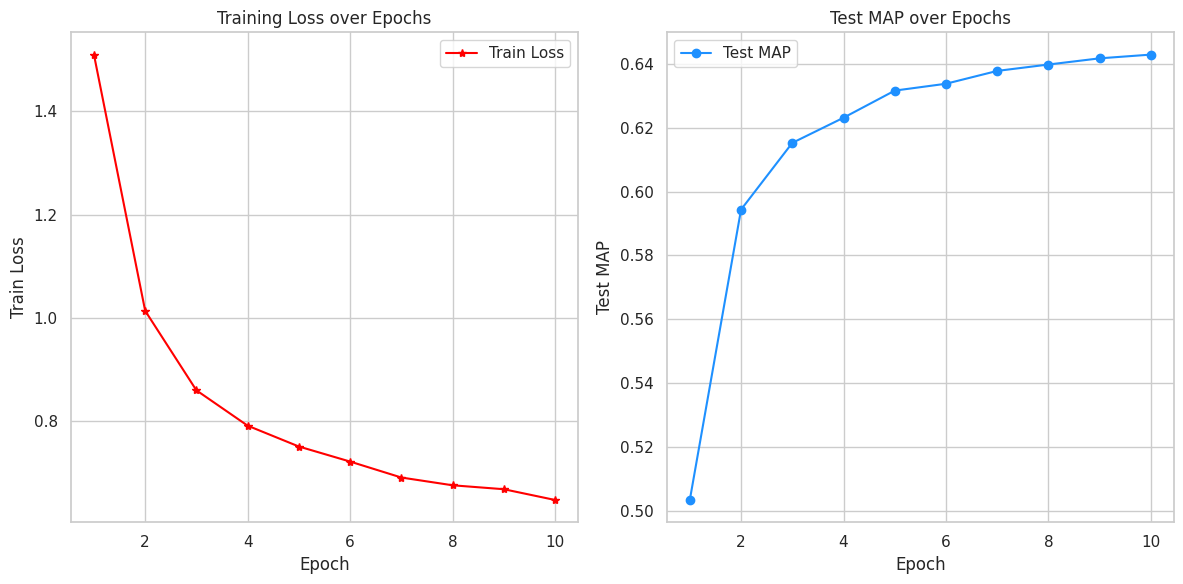

In [ ]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, '-*', label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_maps, '-o', label='Test MAP', color='dodgerblue')
plt.xlabel('Epoch')
plt.ylabel('Test MAP')
plt.title('Test MAP over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

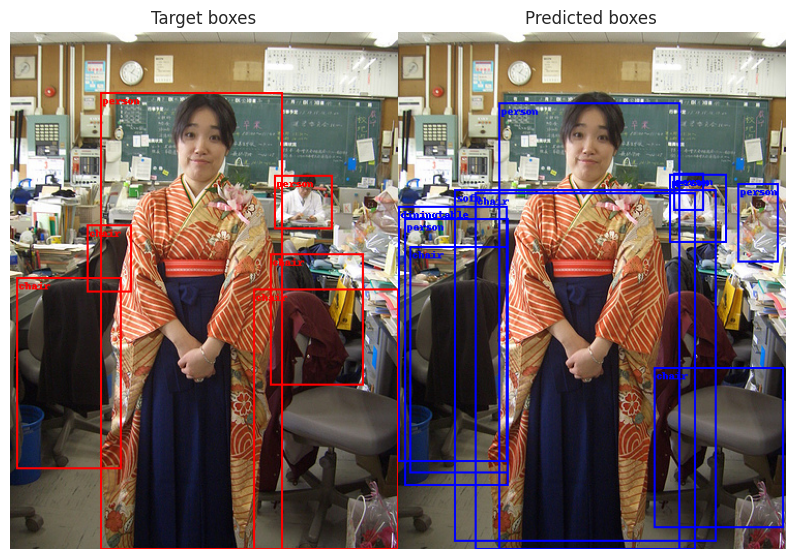

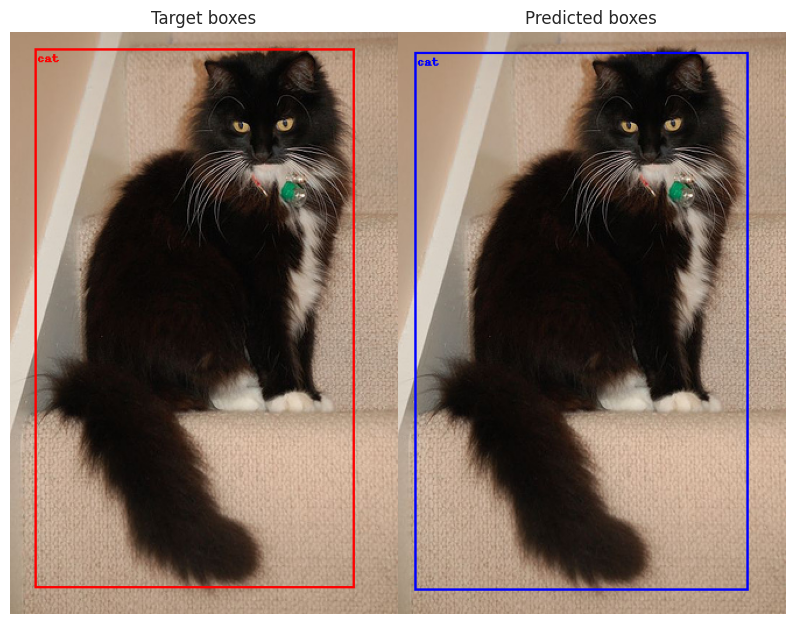

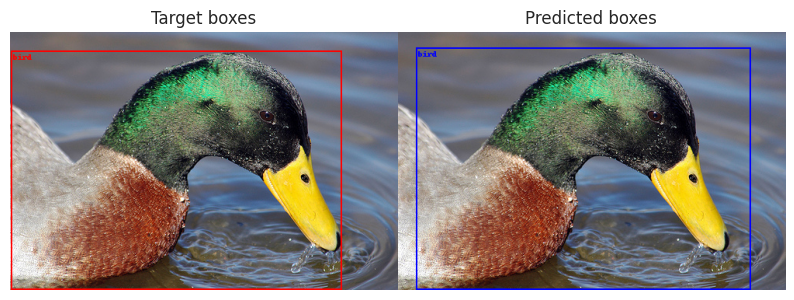

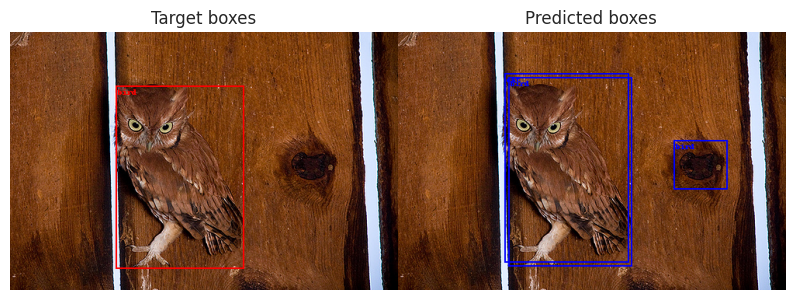

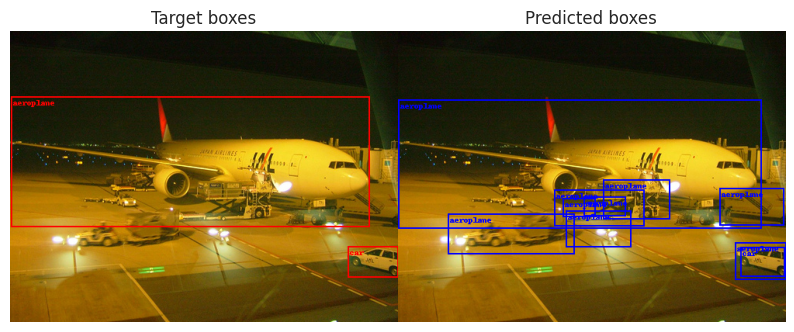

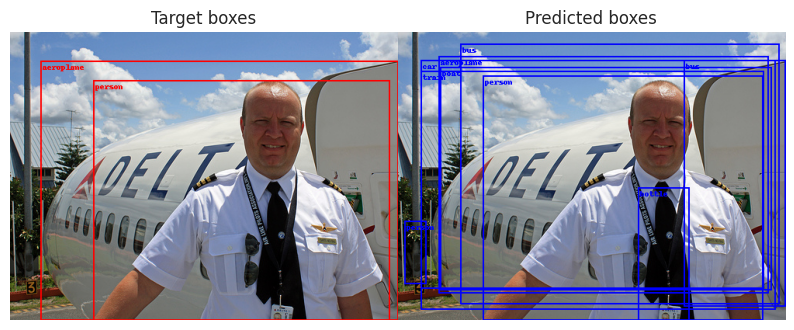

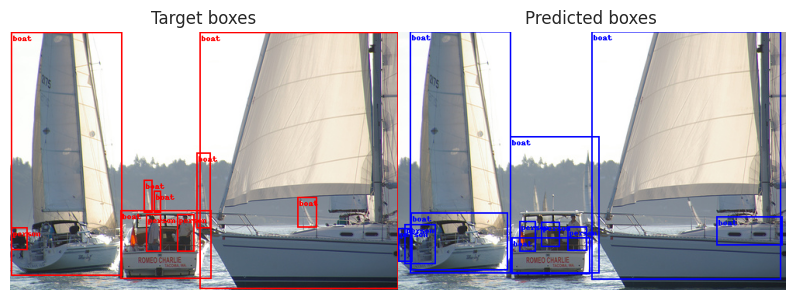

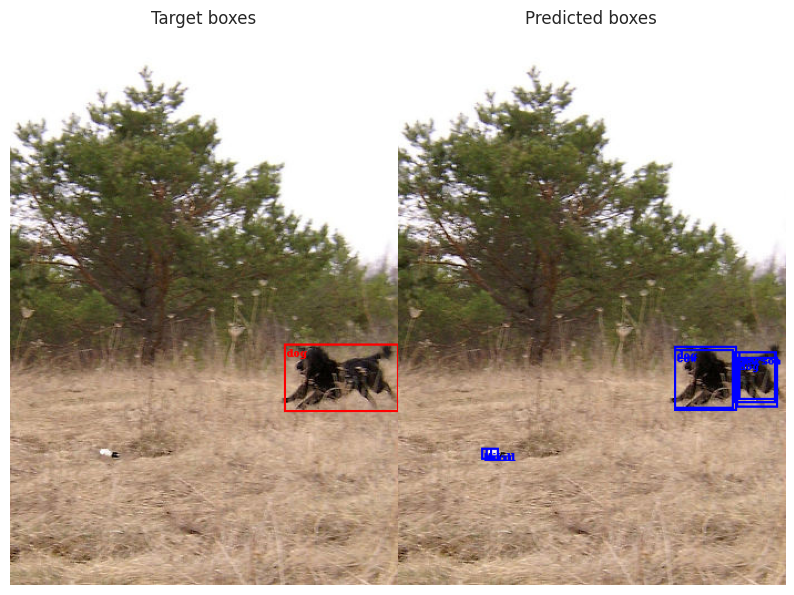

In [ ]:
visualize(modelRCNN, next(iter(validation_loader)))

In [1]:
%pip install -q nbconvert

In [11]:
# !sudo apt-get update
# !sudo apt-get install texlive-xetex texlive-fonts-recommended
# !sudo apt-get install texlive-latex-extra

In [12]:
!jupyter nbconvert --to pdf '/content/A42865_MidtermTestProject_ObjectDetection.ipynb'

[NbConvertApp] Converting notebook /content/A42865_MidtermTestProject_ObjectDetection.ipynb to pdf
[NbConvertApp] Support files will be in A42865_MidtermTestProject_ObjectDetection_files/
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetection_files
[NbConvertApp] Making directory ./A42865_MidtermTestProject_ObjectDetectio